In [30]:
import xarray as xr
from calculate_exposure_to_haz import *
import numpy as np
exposures_dict = get_exposures(haz_type='RF')


In [31]:
import pandas as pd
import numpy as np
from climada.hazard import Hazard
import xarray as xr
import sparse
import scipy
matrices=[]
# Rename columns

# Extract years from the `time` dimension
unique_years = np.arange(2003,2022)

# Initialize an empty list to store the hazards
yearly_hazards = {}

# Loop over each unique year
for year in unique_years:
    file = f"/Users/szelie/OneDrive - ETH Zurich/data/health_multi_risk_data/hazard_input_data/isimip3a/flood_fraction/cama-flood_ensemble_median_20crv3-era5_obsclim_histsoc_default_fldfrc_15arcmin_global_month-max_2y_{year}.nc"

    yearly_hazard = xr.open_dataset(file)
    #yearly_hazard['longitude'] = yearly_hazard['longitude'].where(yearly_hazard['longitude'] <= 180, yearly_hazard['longitude'] - 360)

#     # Convert it into a hazard
    yearly_hazard = Hazard.from_xarray_raster(yearly_hazard, hazard_type='RF', intensity_unit='fraction', intensity='fldfrc')
#     # Append the hazard to the list
    yearly_hazards[year] = yearly_hazard



In [32]:
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

impf_set = ImpactFuncSet()

impfhw = ImpactFunc()
impfhw.id = 1
impfhw.haz_type = 'RF'
impfhw.name = 'Step function rf'
impfhw.intensity_unit = ''
impfhw.intensity = np.array([0, 0.05, 0.5, 1])
impfhw.mdd = np.array([0, 0.05, 0.5, 1])
impfhw.paa = np.ones(impfhw.intensity.shape)
impfhw.check()
impf_set.append(impfhw)

<Axes: title={'center': 'RF 1: Step function rf'}, xlabel='Intensity ()', ylabel='Impact (%)'>

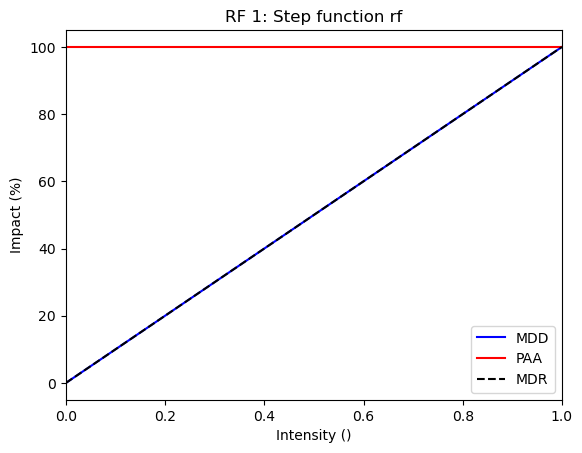

In [33]:
impfhw.plot() # here the hazard is a fraction flooded, so if we have 0.1, 10 percent of the grid cell is exposed

In [34]:
exposures_dict['all']['2003'].gdf

,latitude,longitude,value,impf_RF
0,-90.0,0.00,0.0,1
1,-90.0,0.25,0.0,1
2,-90.0,0.50,0.0,1
3,-90.0,0.75,0.0,1
4,-90.0,1.00,0.0,1
...,...,...,...,...
1038235,90.0,-1.25,0.0,1
1038236,90.0,-1.00,0.0,1
1038237,90.0,-0.75,0.0,1
1038238,90.0,-0.50,0.0,1


In [35]:
from climada.engine import Impact, ImpactCalc

impact_dict={age:{year:ImpactCalc(exposures_dict[age][str(year)], impf_set, yearly_hazards[year]).impact(save_mat=True) for year in unique_years} for age in exposures_dict}
for age in impact_dict:
    for year in impact_dict[age]:
        impact_dict[age][year].tot_value=0 #if not same value everywhere, cannot concatenate 


impact_dict_no_change_vuln_pop={age:{year:ImpactCalc(exposures_dict[age]['2003'], impf_set, yearly_hazards[year]).impact(save_mat=True) for year in unique_years} for age in exposures_dict}
for age in impact_dict_no_change_vuln_pop:
    for year in impact_dict_no_change_vuln_pop[age]:
        impact_dict_no_change_vuln_pop[age][year].tot_value=0



2024-08-28 16:44:00,659 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-28 16:44:00,663 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-28 16:44:00,663 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-28 16:44:00,663 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-28 16:44:00,663 - climada.engine.impact - WARNING - The 

In [36]:
impact_concat = {}
impact_concat_no_change_vuln_pop = {}
for age in impact_dict:
    impact_concat[age] = Impact.concat(list(impact_dict[age].values()),reset_event_ids=True)
    impact_concat_no_change_vuln_pop[age] = Impact.concat(list(impact_dict_no_change_vuln_pop[age].values()),reset_event_ids=True)

2024-08-28 16:46:28,911 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-28 16:46:28,912 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-28 16:46:28,912 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-28 16:46:28,912 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-28 16:46:28,912 - climada.engine.impact - WARNING - The 

In [37]:
for age in impact_dict:
    write_impact(impact_concat[age], 'RF', age) 
    write_impact(impact_concat_no_change_vuln_pop[age], 'RF_ec', age)


In [38]:
import datetime
len([datetime.date.fromordinal(date) for date in impact_concat[age].date])

228